#  Data Science 100 - Final Group Report

GitHub: https://github.com/Jmmchai/Dsci-100-004-group02.git

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
library(RColorBrewer)
options(repr.matrix.max.rows = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

In this project we are analyzing data from a video game research server, specifically a Minecraft Server. This project is run by a UBC Computer Science research group led by Frank Wood, and they are interested in collecting data about how people play video games. The server set-up records players actions as they navigate the Minecraft world. 

The main problem is that, to ensure resources like server hardware and software licenses are sufficient, developers need to identify their main target audience, who they should dedicate resources to attract. This is why we will analyze and wrangle the data to help them identify their target audience/players. 

# 1. Questions

For this final report, we have decided to address the first general question, **"What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**. 

Specifically, we will aim to answer the question: **Can we predict whether a player subscribes to the newsletter based on their age, experience, and total hours played from the *players* dataset?**

To answer our specific question, we have decided to use the *players* dataset. There are some issues with this dataset, namely the bias due to size and outliers. For the age and played_hours variables, there are some outlier variables, which could skew our visualizations, and mean calculation. It could also harm our classification model because the model will rely on neighbors to make predictions, and if the neighbors are not reflective (biased) of the data, then the model will make an inaccurate prediction. Not to mention that some of the played_hour numbers are unrealistic; for example, one player played 223 hours, which seems too extreme. There is also bias in the experience variable because it is not clear how players were split up into these experiences (like what was the criteria or characteristics used?). Additionally, there could be potential sampling bias because what if some of the data collected was not seen as "important" to be reported compared to the rest.

# 2. Data Description

In [3]:
#read in players data
players_url <- "https://raw.githubusercontent.com/Jmmchai/Dsci-100-004-group02/refs/heads/main/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The *players* dataset includes 196 rows, and 7 variables. These 7 variables include:

| Variable Name | Type | Description |
| ------------- | ---- | ----------- |
| Experience | chr | The expereince level of a player (Pro, Veteran, Beginner, Amateur, Regular) |
| Subscribe | lgl | Whether a player is subscribed or not (TRUE/FALSE) | 
| HashedEmail | chr | The email each player uses |
| Played_hours | dbl | The number of hours played by each player |
| Name | chr | Each player's name |
| Gender | chr | Player's gender (Male, Female, Non-binary, Agender, Two-Spirited, Prefer not to say, Other) |
| Age | dbl | Player's age |

# 3. Data Wrangling

In [4]:
players_clean <- players |>
select(subscribe, Age, experience, played_hours) |>
mutate(subscribe = as.factor(subscribe), experience = as.factor(experience)) |>
filter(!is.na(Age), !is.na(played_hours), !is.na(experience))
players_clean

subscribe,Age,experience,played_hours
<fct>,<dbl>,<fct>,<dbl>
TRUE,9,Pro,30.3
TRUE,17,Veteran,3.8
FALSE,17,Veteran,0.0
TRUE,21,Amateur,0.7
⋮,⋮,⋮,⋮
TRUE,17,Amateur,0.0
FALSE,22,Veteran,0.3
FALSE,57,Amateur,0.0
FALSE,17,Amateur,2.3


For the above wrangling, we only selected our predictor variables (Age, experience, played_hours), and variable of interest (subscribe). We also changed the *subscribe* and *experience* variables to factors instead of characters. This will make them easier to use if we want to color/fill a plot by a specific variable. Finally, we filtered out any players who had missing data from any variable to avoid it messing up our analysis.

# 4. Data Visualizations

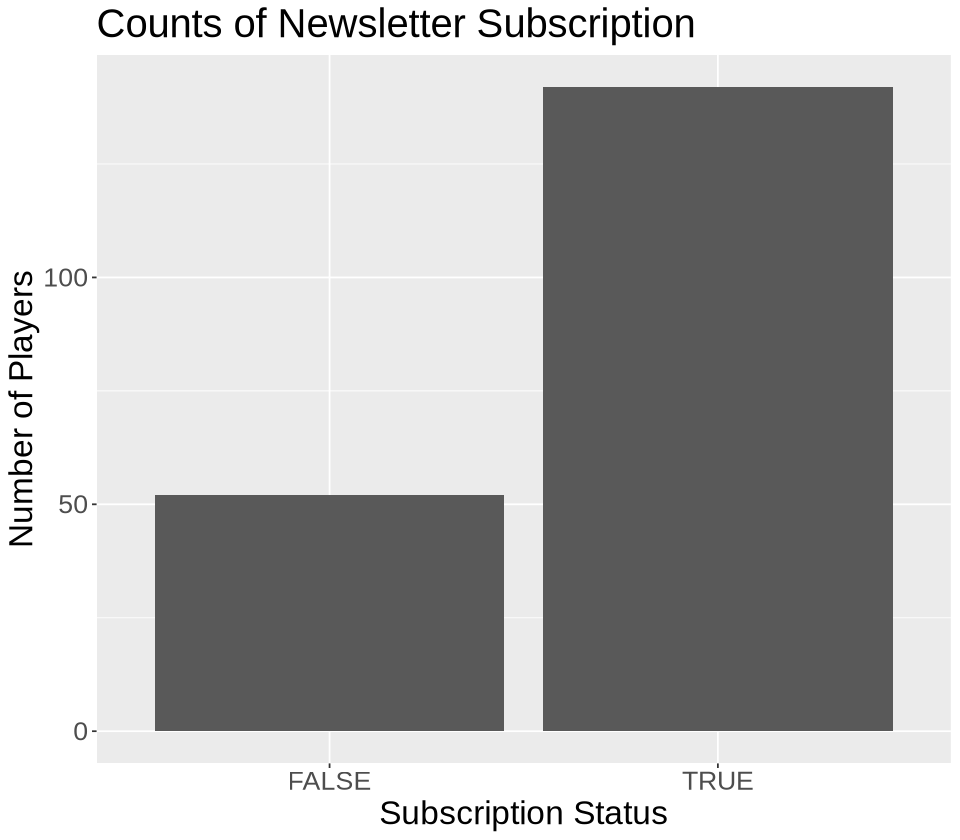

In [5]:
options(repr.plot.width = 8, repr.plot.length = 10)

#show plot to visualize count of players currently subscribed to newsletter

experience_dist <- players_clean |>
                     ggplot(aes(x = subscribe)) +
                     geom_bar() +
                     labs(title = "Counts of Newsletter Subscription", x = "Subscription Status", y = "Number of Players")+
                    theme(text = element_text(size = 20))
experience_dist

From the above visualization, we see that from the current set of players, more are subscribed. Further wrangling (using filter()).  would help us determine that from the current 196 players, 144 are subscribed (73.5%) and 52 are not subscribed (26.5%). 

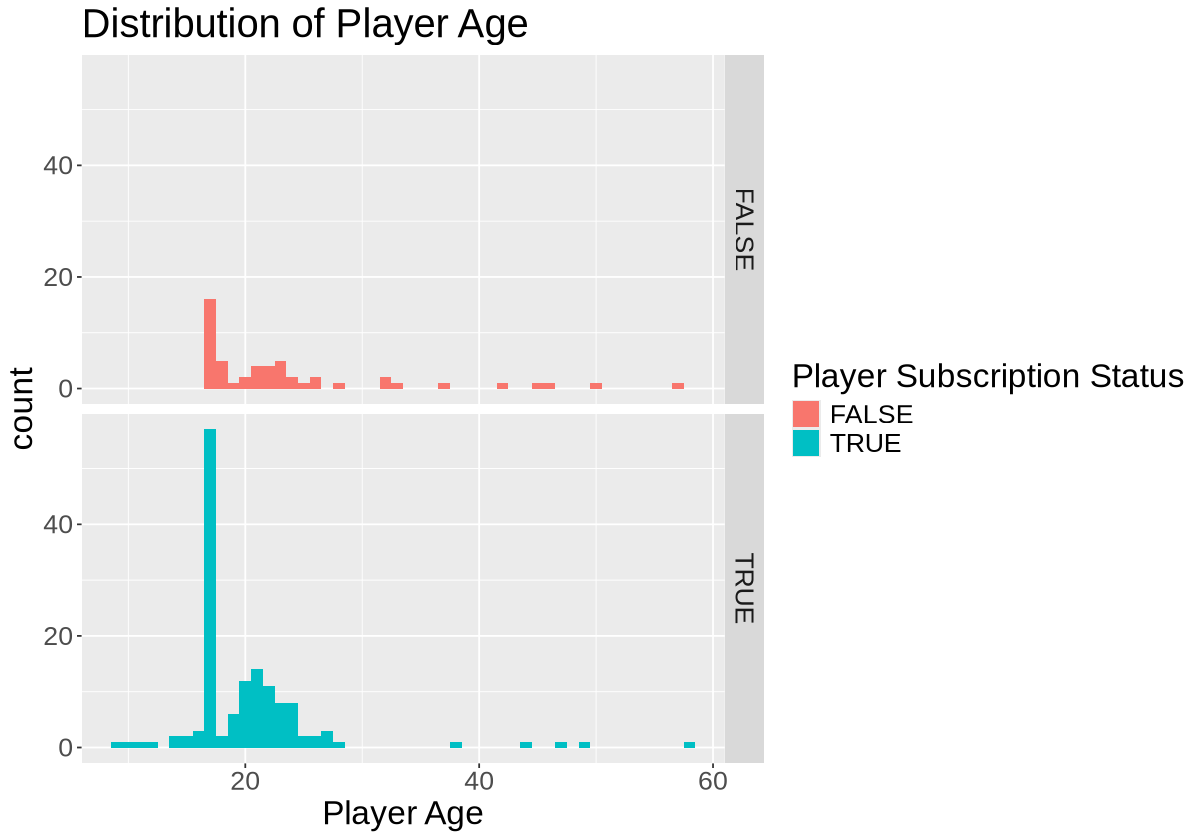

In [6]:
options(repr.plot.width = 10, repr.plot.length = 14)

#show distribution of player age
age_experience_dist <- players_clean |>
                        ggplot(aes(x = Age, fill = as.factor(subscribe)))+
                        geom_histogram(binwidth = 1)+
                        facet_grid(rows = vars(subscribe))+
                        labs(x = "Player Age", y = "count", fill = "Player Subscription Status")+
                        ggtitle("Distribution of Player Age")+
                        theme(text = element_text(size = 20))
age_experience_dist

From the above plot, we see that most players are between 15-25 years (with the most being around 18 years). We also see that a majority of the current players are subscribed, especially the players that lie in the 15-25 age group.

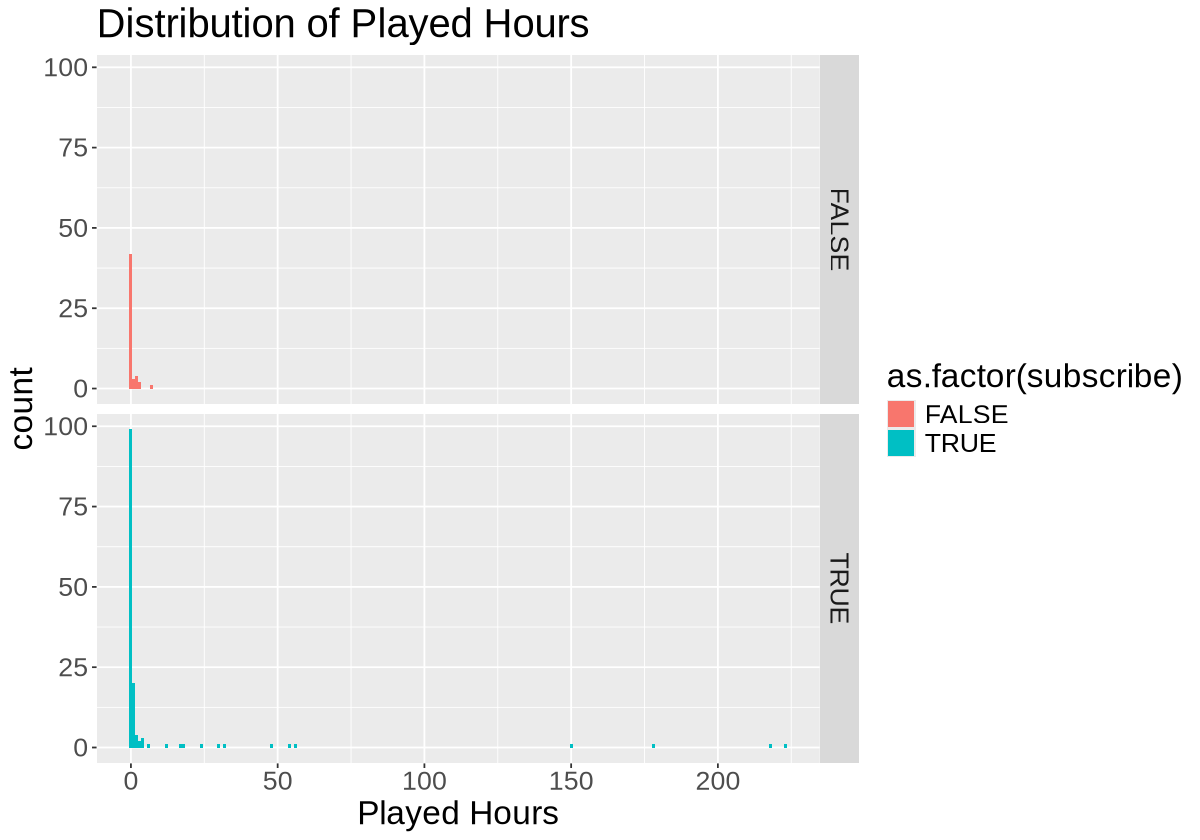

In [7]:
options(repr.plot.width = 10, repr.plot.length = 14)

#show distribution of played_hours
played_hours_dist <- players_clean |>
                    ggplot(aes(x = played_hours, fill = as.factor(subscribe)))+
                    geom_histogram(binwidth = 1)+
                    facet_grid(rows = vars(subscribe))+
                    labs(x = "Played Hours", y = "count")+
                    ggtitle("Distribution of Played Hours")+
                    theme(text = element_text(size = 20))
played_hours_dist

The above plot shows that there is no direct relationship between **played_hours** and **subscribe**, but we see that most of the players are subscribed. 

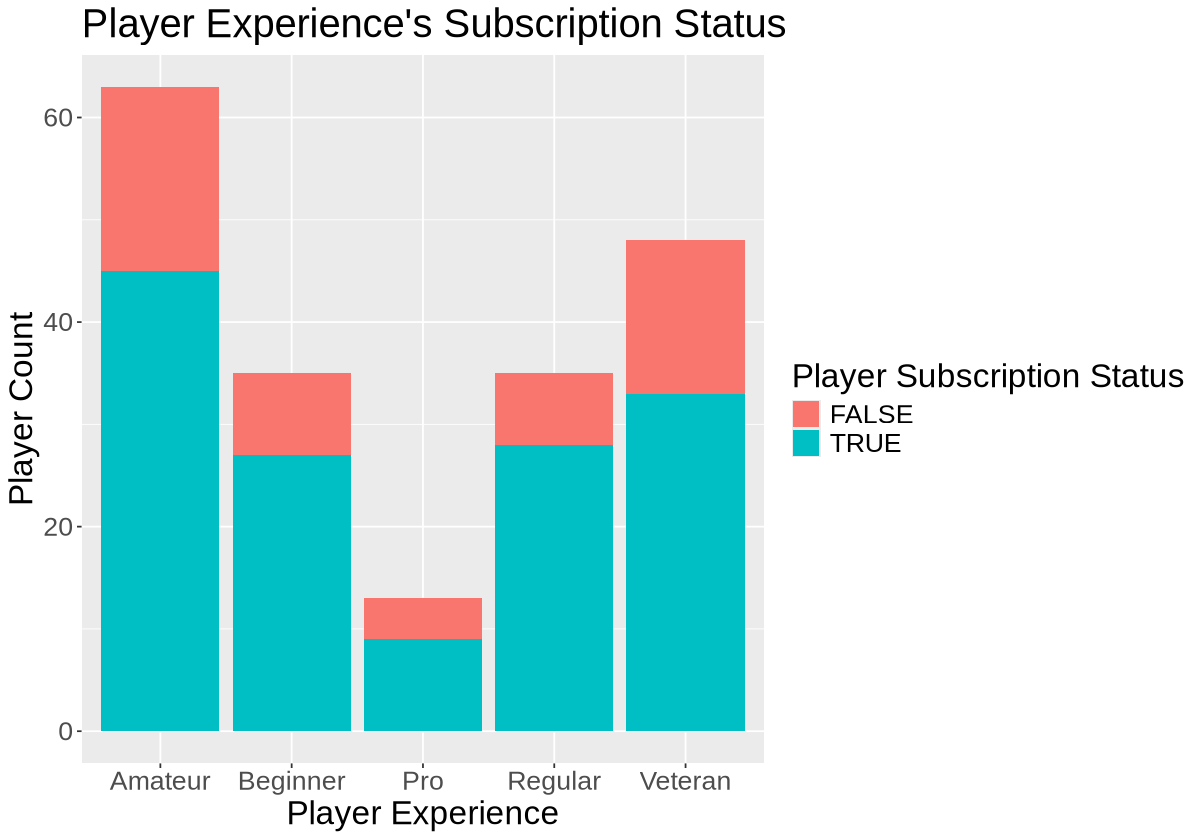

In [10]:
options(repr.plot.width = 10, repr.plot.length = 14)

#visualize relationship between experience and subscription
experience_subscription <- players_clean |>
                            ggplot(aes(x = experience, fill = as.factor(subscribe)))+
                            geom_bar()+
                            labs(x = "Player Experience", y = "Player Count", fill = "Player Subscription Status")+
                            ggtitle("Player Experience's Subscription Status")+
                            theme(text = element_text(size = 20))
experience_subscription

From the plot above, we see that most of the subscribed players are either amateurs or veterans. We also see that not many pro players play this game, which can suggest that this game might not be challenging enough for pros. There is no exact relationship between **subscribe** and **experience**, but it is clear that in each experience category, more players are subscribed to the newsletter.

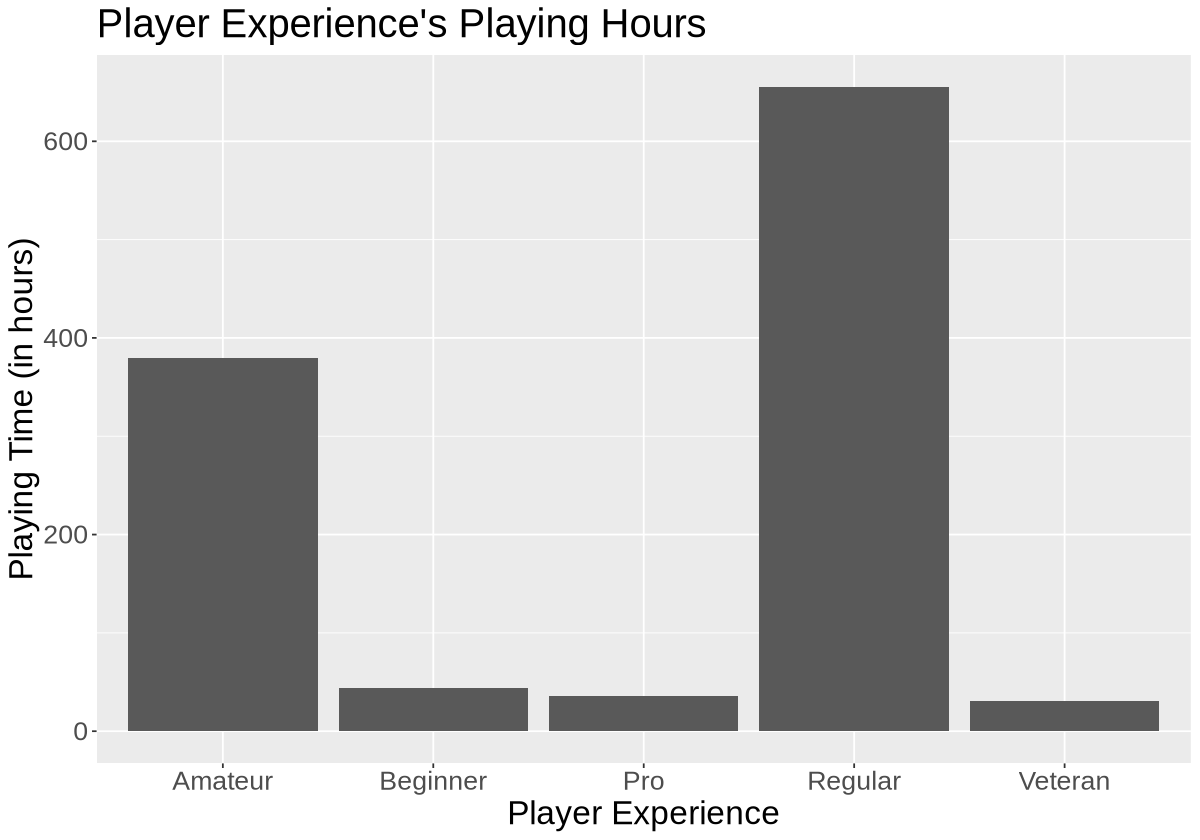

In [11]:
options(repr.plot.width = 10, repr.plot.length = 14)

#visualize relationship between experience and subscription
experience_subscription <- players_clean |>
                            ggplot(aes(x = experience, y = played_hours))+
                            geom_bar(stat = "identity")+
                            labs(x = "Player Experience", y = "Playing Time (in hours)")+
                            ggtitle("Player Experience's Playing Hours")+
                            theme(text = element_text(size = 20))
experience_subscription

From the above graph we see that regular-experience players have the highest total playing time, and amateur players have the second highest playing time. The beginner, pro, and veteran players don't have a very high playing time.

# 5. Methods

We have decided to make a classification model because we are interested in predicting whether a player will subscribe to the newsletter, which is a categorical prediction. However, since our model can only use numeric values to make the predictions, we needed to use the *dummy* function to make our ***experience*** variable numeric. 

In [8]:
#split data into 75% training and 25% testing
set.seed(666)
players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

We decided to split our data into 75% training and 25% testing. It is important we do this so we can prevent the model from "cheating" when making predictions.

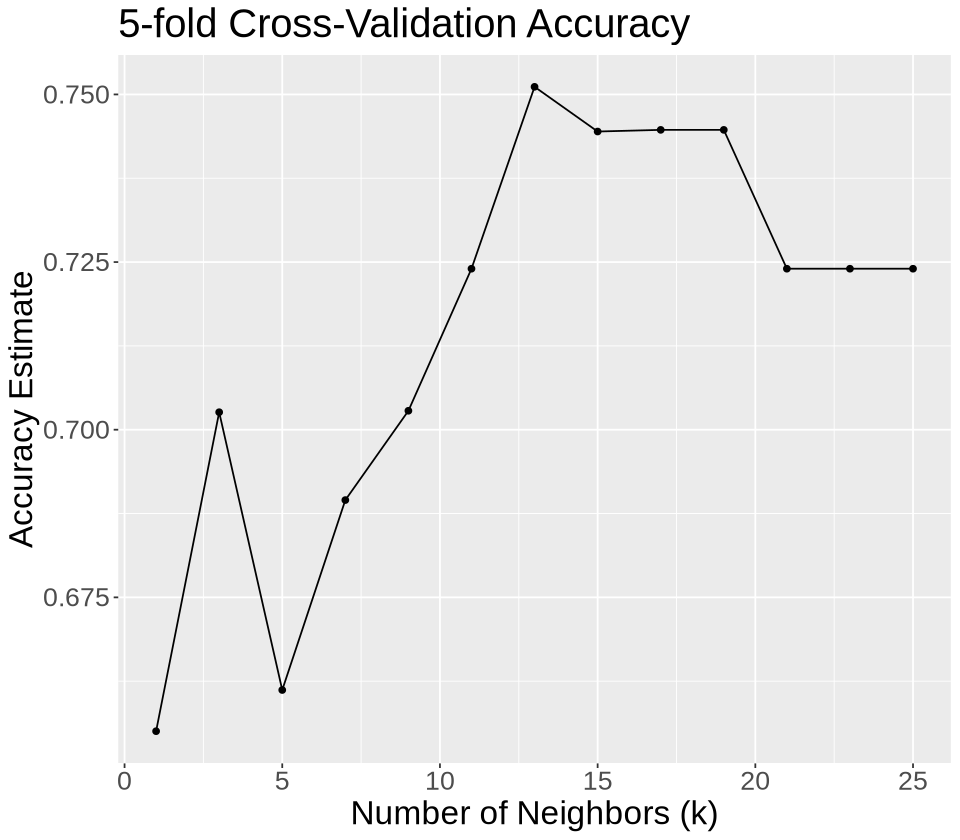

In [9]:
#choose best K
set.seed(666)
players_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

players_recipe <- recipe(subscribe ~ experience + played_hours + Age, data = players_training) |>
                    step_dummy(experience) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

knn_result <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = tibble(neighbors = c(1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25))) |>
  collect_metrics()

accuracies <- knn_result |>
  filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (k)", y = "Accuracy Estimate", title = "5-fold Cross-Validation Accuracy") +
  theme(text = element_text(size = 20))

cross_val_plot

From the above cross-validation accuracy plot, we see that the best *k* to use would be ***k = 13*** because it gives us the highest accuracy of around 75%. 

In [62]:
set.seed(666)

#edit model to include k = 13 as number of neighbors
players_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = 13) |>
                set_engine("kknn") |>
                set_mode("classification")

players_fit <- workflow() |>
                add_recipe(players_recipe) |>
                add_model(players_spec) |>
                fit(data = players_training)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_dummy()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.262069
Best kernel: rectangular
Best k: 13

In [63]:
set.seed(666)
players_test_predictions <- predict(players_fit, players_testing) |>
bind_cols(players_testing)

players_test_predictions

.pred_class,subscribe,Age,experience,played_hours
<fct>,<fct>,<dbl>,<fct>,<dbl>
TRUE,TRUE,17,Veteran,3.8
TRUE,FALSE,17,Veteran,0.0
FALSE,TRUE,47,Amateur,0.1
TRUE,TRUE,17,Amateur,48.4
⋮,⋮,⋮,⋮,⋮
TRUE,FALSE,17,Pro,0.2
TRUE,TRUE,17,Beginner,0.0
TRUE,TRUE,17,Amateur,0.0
TRUE,FALSE,17,Amateur,2.3


In [64]:
set.seed(666)
players_prediction_accuracy <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

players_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71428571
kap,binary,-0.03939394


In [65]:
set.seed(666)
players_mat <- players_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

players_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

# 6. Discussion & Conclusion

#### 1. Summarize
This project analyzed data from a Minecraft research server to predict player newsletter subscription status using age, experience, and total hours played. Exploratory analysis revealed a significant class imbalance, with 73.5% of the 196 players subscribed. Players were concentrated in the 15–25 age range, and Regular-experience players showed the highest playing time and subscription rate. A K-Nearest Neighbors (k-NN) classifier was used for prediction, and the optimal k=13 resulted in a final test accuracy of 71.4%. However, the confusion table exposed a critical flaw: the model maximized its accuracy by predicting the majority class (subscribed) almost universally, correctly identifying 35 out of 36 true subscribers but failing to learn any features to distinguish non-subscribers.

#### 2. Whether this is what we expected to find
The high overall subscription rate was plausible given that the data originated from a research server where high player engagement is expected. However, the resulting performance of the k-NN model was unexpected. The moderate 71.4% accuracy was misleading because the model took advantage of the severe class imbalance — with roughly three times as many subscribers as non-subscribers — which was demonstrated by the model’s failure to correctly classify almost any true non-subscribers. This indicated that the model did not genuinely learn predictive features for non-subscription, instead defaulting to the majority-class prediction, which greatly reduces its practical predictive utility despite the seemingly acceptable accuracy score.

#### 3. Impact could have
Although the model achieved a seemingly acceptable accuracy of 71.4%, our deeper evaluation using Cohen’s kappa and the confusion matrix indicated a severe class imbalance issue. This could lead to poor decision-making in real-world application. If identifying non-subscribers are important in making decisions or developing strategic targets, the consequence of misleading will be more severe. So, without properly handling the class imbalance of data, the model will fail to provide reliable or valuable information about minority groups.

#### 4. Future questions could lead to
There are several questions for future study. One question is whether adding more factors as predictors could improve the performance of the model, such as login frequency, number of playing sessions, or other behavioral factors. Another question is related to the class imbalance, which is the main problem in our modeling process. We would need to increase the number of non-subscribers or reduce the number of subscribers to create a more balanced dataset, which would lead to more reliable predictions for both types of players.